Intro

In [1]:
import requests
import pandas as pd

url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
documents = requests.get(docs_url).json()

ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
df_ground_truth = pd.read_csv(ground_truth_url)
ground_truth = df_ground_truth.to_dict(orient='records')

In [24]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [25]:
ground_truth[0]

{'question': 'When does the course begin?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [4]:
from tqdm.auto import tqdm

def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)

def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

Q1

In [5]:
import minsearch

index = minsearch.Index(
    text_fields=["question", "text", "section"],
    keyword_fields=["course", "id"]
)

index.fit(documents)

In [6]:
def minsearch_search(query, course):
    boost = {'question': 1.5, 'section': 0.1}

    results = index.search(
        query=query,
        filter_dict={'course': course},
        boost_dict=boost,
        num_results=5
    )

    return results

In [7]:
evaluate(ground_truth, lambda q: minsearch_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.848714069591528, 'mrr': 0.7288235717887772}

Q2

In [26]:
from minsearch import VectorSearch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [27]:
texts = []

for doc in documents:
    t = doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [28]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [36]:
def minsearch_vector_search(query, course):
    query_vec = pipeline.transform([query])[0] 
    results = vindex.search(
        query_vec,
        filter_dict={'course': course},
        num_results=5
        )

    return results

In [37]:
evaluate(ground_truth, lambda q: minsearch_vector_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.48173762697212014, 'mrr': 0.3572833369353793}

In [35]:
help(VectorSearch)

Help on class VectorSearch in module minsearch.vector:

class VectorSearch(builtins.object)
 |  VectorSearch(keyword_fields)
 |
 |  A vector search index using cosine similarity for vector search and exact matching for keyword fields.
 |
 |  Takes a 2D numpy array of vectors and a list of payload documents, providing efficient
 |  similarity search with keyword filtering and boosting capabilities.
 |
 |  Methods defined here:
 |
 |  __init__(self, keyword_fields)
 |      Initialize the VectorSearch index.
 |
 |      Args:
 |          keyword_fields (list): List of keyword field names to index for exact matching.
 |
 |  fit(self, vectors, payload)
 |      Fits the index with the provided vectors and payload documents.
 |
 |      Args:
 |          vectors (np.ndarray): 2D numpy array of shape (n_docs, vector_dimension).
 |          payload (list of dict): List of documents to use as payload. Each document is a dictionary.
 |
 |  search(self, query_vector, filter_dict=None, num_results=10

Q3

In [39]:
texts = []

for doc in documents:
    t = doc['question'] + ' ' + doc['text']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
X = pipeline.fit_transform(texts)

In [40]:
vindex = VectorSearch(keyword_fields={'course'})
vindex.fit(X, documents)

In [41]:
def minsearch_vector_search(query, course):
    query_vec = pipeline.transform([query])[0] 
    results = vindex.search(
        query_vec,
        filter_dict={'course': course},
        num_results=5
        )

    return results

In [42]:
evaluate(ground_truth, lambda q: minsearch_vector_search(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.8210503566025502, 'mrr': 0.6717347453353508}

Q4

In [57]:
from qdrant_client import QdrantClient, models

In [58]:
qd_client = QdrantClient("http://localhost:6333")

In [59]:
EMBEDDING_DIMENSIONALITY = 512
model_handle = "jinaai/jina-embeddings-v2-small-en"

In [60]:
collection_name = "hw3-faq"

In [61]:
qd_client.delete_collection(collection_name=collection_name)

True

In [62]:
qd_client.create_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=EMBEDDING_DIMENSIONALITY,
        distance=models.Distance.COSINE
    )
)

True

In [63]:
qd_client.create_payload_index(
    collection_name=collection_name,
    field_name="course",
    field_schema="keyword"
)

UpdateResult(operation_id=1, status=<UpdateStatus.COMPLETED: 'completed'>)

In [64]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

In [65]:
points = []

for i, doc in enumerate(documents):
    text = doc['question'] + ' ' + doc['text']
    vector = models.Document(text=text, model=model_handle)
    point = models.PointStruct(
        id=i,
        vector=vector,
        payload=doc
    )
    points.append(point)

In [66]:
qd_client.upsert(
    collection_name=collection_name,
    points=points
)

UpdateResult(operation_id=2, status=<UpdateStatus.COMPLETED: 'completed'>)

In [67]:
def vector_search_qdrant(question, course):
    
    course = course
    query_points = qd_client.query_points(
        collection_name=collection_name,
        query=models.Document(
            text=question,
            model=model_handle 
        ),
        query_filter=models.Filter( 
            must=[
                models.FieldCondition(
                    key="course",
                    match=models.MatchValue(value=course)
                )
            ]
        ),
        limit=5,
        with_payload=True
    )
    
    results = []
    
    for point in query_points.points:
        results.append(point.payload)
    
    return results

In [68]:
evaluate(ground_truth, lambda q: vector_search_qdrant(q['question'], q['course']))

  0%|          | 0/4627 [00:00<?, ?it/s]

{'hit_rate': 0.9299762264966501, 'mrr': 0.8517722066133576}

Q 5

In [88]:
import numpy as np

In [89]:
url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
results_url = url_prefix + 'rag_evaluation/data/results-gpt4o-mini.csv'
df_results = pd.read_csv(results_url)
results_dict = df_results.to_dict(orient='records')

In [90]:
def normalize(u):
    norm = np.sqrt(u.dot(u))
    return u / norm

In [91]:
def cosine(u, v):
    u = normalize(u)
    v = normalize(v)
    return u.dot(v)

In [92]:
record = results_dict[0]
record

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [93]:
texts = []

for doc in results_dict:
    t = doc['answer_llm'] + ' ' + doc['answer_orig']  + ' ' + doc['question']
    texts.append(t)

pipeline = make_pipeline(
    TfidfVectorizer(min_df=3),
    TruncatedSVD(n_components=128, random_state=1)
)
pipeline.fit(texts)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(min_df=3)),
                ('truncatedsvd',
                 TruncatedSVD(n_components=128, random_state=1))])

In [94]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = pipeline.transform([answer_orig])[0]
    v_orig = pipeline.transform([answer_llm])[0]
    
    return cosine(v_llm,v_orig)

In [95]:
similarity = []

for record in tqdm(results_dict):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [115]:
df_results['cosine'] = similarity
df_results['cosine'].describe()

count    1830.000000
mean        0.841584
std         0.173737
min         0.079093
25%         0.806927
50%         0.905812
75%         0.950711
max         0.996457
Name: cosine, dtype: float64

In [97]:
import seaborn as sns

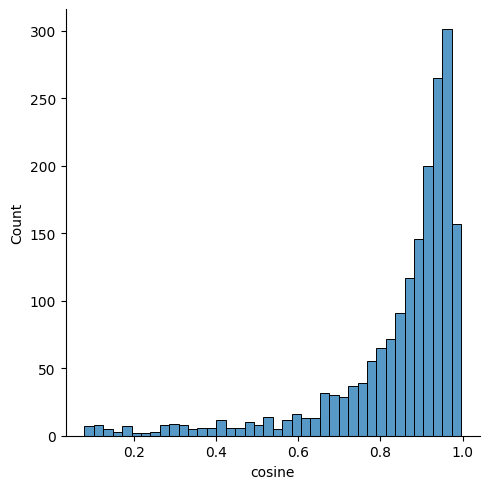

In [98]:
sns.displot(df_results['cosine'])

Q6

In [99]:
! pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [107]:
from rouge import Rouge
rouge_scorer = Rouge()

r = df_results.iloc[10]
scores = rouge_scorer.get_scores(r.answer_llm, r.answer_orig)[0]
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

In [108]:
r

answer_llm     Yes, all sessions are recorded, so if you miss...
answer_orig    Everything is recorded, so you won’t miss anyt...
document                                                5170565b
question                    Are sessions recorded if I miss one?
course                                 machine-learning-zoomcamp
cosine                                                  0.770935
Name: 10, dtype: object

In [109]:
scores['rouge-1']['f']

0.45454544954545456

In [110]:
results_dict[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [111]:
def compute_rouge(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    return rouge_scorer.get_scores(answer_llm, answer_orig)[0]['rouge-1']['f']

In [112]:
rouge_scores = []

for record in tqdm(results_dict):
    rouge = compute_rouge(record)
    rouge_scores.append(rouge)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [114]:
df_results['f1_rouge_score'] = rouge_scores
df_results['f1_rouge_score'].describe()

count    1830.000000
mean        0.351695
std         0.158905
min         0.000000
25%         0.238887
50%         0.356300
75%         0.460133
max         0.950000
Name: f1_rouge_score, dtype: float64

In [116]:
df_results

,answer_llm,answer_orig,document,question,course,cosine,f1_rouge_score
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp,0.463526,0.095238
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp,0.781565,0.125000
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp,0.889158,0.415584
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp,0.614962,0.216216
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp,0.624086,0.142076
...,...,...,...,...,...,...,...
1825,Some suggested titles for listing the Machine ...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp,0.907584,0.336134
1826,It is best advised that you do not list the Ma...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp,0.965069,0.453782
1827,You can incorporate your Machine Learning Zoom...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp,0.965395,0.442748
1828,The advice on including a project link in a CV...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp,0.716734,0.191489


In [120]:
import matplotlib.pyplot as plt

/tmp/ipykernel_12892/1678788615.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['cosine'], label="cosine")
/tmp/ipykernel_12892/1678788615.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['f1_rouge_score'], label="f1_rouge_score")


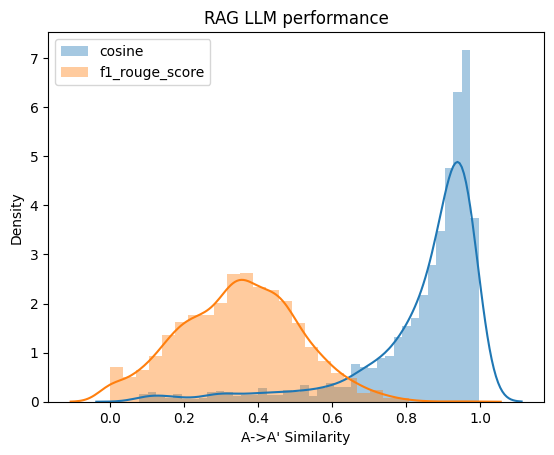

In [123]:
sns.distplot(df_results['cosine'], label="cosine")
sns.distplot(df_results['f1_rouge_score'], label="f1_rouge_score")
plt.title("RAG LLM performance")
plt.xlabel("A->A' Similarity")
plt.legend()